In [1]:
#import packages
from time import time
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, KMeansSMOTE
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

In [2]:
#reading data
df = pd.read_csv("fake_job_postings.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [3]:
#Function to preprocess
# df['text']=df['text'].str.lower()
def preprocess(df):
    df = df[df.location.notnull()]
    df = df[df.function.notnull()]
    df= df[df.location.str.contains("US,")] 
    df['description']=df['description'].str.lower()
    return df

df = preprocess(df) 

In [4]:
df = df[df.function.isin(df['function'].value_counts()[df['function'].value_counts() > 260].index.tolist())]

In [5]:
df.function.unique()
len(df.function.unique())

8

In [6]:
df.function.value_counts()



Customer Service          955
Sales                     951
Information Technology    765
Engineering               690
Administrative            394
Marketing                 390
Education                 292
Health Care Provider      264
Name: function, dtype: int64

In [7]:
#lemmatiaztion
def getLemmText(text):
    tokens=word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens=[lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['description'] = list(map(getLemmText,df['description']))

In [8]:
def getStemmText(text):
    tokens=word_tokenize(text)
    ps = PorterStemmer()
    tokens=[ps.stem(word) for word in tokens]
    return ' '.join(tokens)

df['description'] = list(map(getStemmText,df['description']))
df_text = pd.DataFrame({'function': df.function.tolist() , 'description': df.description.tolist()})
df_text

,function,description
0,Marketing,"food52 , a fast-grow , jame beard award-win on..."
1,Sales,the compani : esri – environment system resear...
2,Health Care Provider,job titl : item review managerloc : fort worth...
3,Customer Service,the custom servic associ will be base in phoen...
4,Information Technology,posit : # url_86fd830a95a64e2b30ceed829e63fd38...
...,...,...
4696,Information Technology,perform basic workstat troubl analysi to inclu...
4697,Engineering,what we 're look for : you 've been an integr ...
4698,Information Technology,"posit : sr. sql server dbaloc : bay area , cad..."
4699,Health Care Provider,crossroad treatment center in south carolina i...


In [9]:
df_text['description']= df_text['description'].astype(str)

In [10]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701 entries, 0 to 4700
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   function     4701 non-null   object
 1   description  4701 non-null   object
dtypes: object(2)
memory usage: 73.6+ KB


In [11]:
#Loading Glove Embedding
embeddings_index = {}
f = open('glove.6B.50d.txt', encoding='utf8')
for line in tqdm(f):
    value = line.split()
    word = value[0]
    coef = np.asarray(value[1:], dtype='float32')
    embeddings_index[word] = coef
f.close()
print(len(embeddings_index))

400000it [00:31, 12769.83it/s]

400000


In [12]:
VOCABULARY_SIZE = 2000
MAX_LENGTH = 100

In [13]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(df_text.function)
encoded_Y = encoder.transform(df_text.function)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [14]:
train_x, test_x, train_y, test_y = train_test_split(df_text.description, dummy_y, test_size=0.2, random_state=0)

In [15]:
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
tokenizer.fit_on_texts(list(train_x) + list(test_x))

xtrain_sequence = tokenizer.texts_to_sequences(train_x)
xtest_sequence = tokenizer.texts_to_sequences(test_x)

xtrain_padding = sequence.pad_sequences(xtrain_sequence, maxlen=MAX_LENGTH)
xtest_padding = sequence.pad_sequences(xtest_sequence, maxlen=MAX_LENGTH)
word_index = tokenizer.word_index

embedding_matrix = np.zeros((len(word_index) + 1, 50))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|████████████████████████████████████████████████████████████████████████| 21330/21330 [00:00<00:00, 189256.35it/s]


In [16]:
xtrain_padding.shape

(3760, 100)

In [17]:
xtrain_padding.shape

(3760, 100)

In [18]:
#LSTM
max_features=VOCABULARY_SIZE
maxlen=MAX_LENGTH
model = Sequential()
# model.add(Embedding(max_features, 40, input_length=maxlen))
model.add(Embedding(len(word_index) + 1,50,weights=[embedding_matrix],input_length=MAX_LENGTH,trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
history = model.fit(xtrain_padding, y=train_y, batch_size=48, epochs=20, verbose=1, validation_data=(xtest_padding,test_y ))

Epoch 1/20
79/79 [==============================] - 85s 732ms/step - loss: 1.8815 - accuracy: 0.2747 - val_loss: 1.6050 - val_accuracy: 0.3645
Epoch 2/20
79/79 [==============================] - 58s 729ms/step - loss: 1.5832 - accuracy: 0.4008 - val_loss: 1.4177 - val_accuracy: 0.4548
Epoch 3/20
79/79 [==============================] - 63s 801ms/step - loss: 1.4563 - accuracy: 0.4511 - val_loss: 1.1194 - val_accuracy: 0.5430
Epoch 4/20
79/79 [==============================] - 62s 783ms/step - loss: 1.3478 - accuracy: 0.4843 - val_loss: 1.1213 - val_accuracy: 0.5664
Epoch 5/20
79/79 [==============================] - 62s 790ms/step - loss: 1.2960 - accuracy: 0.5133 - val_loss: 1.2366 - val_accuracy: 0.5228
Epoch 6/20
79/79 [==============================] - 59s 746ms/step - loss: 1.2072 - accuracy: 0.5407 - val_loss: 0.9914 - val_accuracy: 0.6121
Epoch 7/20
79/79 [==============================] - 56s 712ms/step - loss: 1.1735 - accuracy: 0.5617 - val_loss: 1.0449 - val_accuracy: 0.5994

In [20]:
y_pred = model.predict(xtest_padding)
from sklearn.metrics import precision_recall_fscore_support

In [21]:
print(precision_recall_fscore_support(test_y, y_pred.round(),average='micro'))

(0.7620817843866171, 0.6535600425079703, 0.7036613272311213, None)


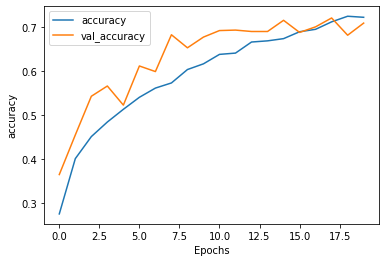

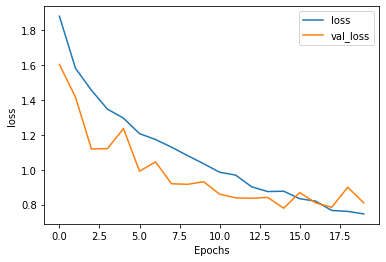

In [24]:
#Model Evaluation
def graph_plots(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

graph_plots(history, "accuracy")
graph_plots(history, "loss")